# State space estimation in Python via Metropolis-Hastings

This post demonstrates how to use the (http://www.statsmodels.org/) `tsa.statespace` package along with the [PyMC](https://pymc-devs.github.io/pymc/) to very simply estimate the parameters of a state space model via the Metropolis-Hastings algorithm (a Bayesian posterior simulation technique).

Although the technique is general to any state space model available in Statsmodels and also to any custom state space model, the provided example is in terms of the local level model and the equivalent ARIMA(0,1,1) model.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pymc as mc
from scipy import signal
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn

np.set_printoptions(precision=4, suppress=True, linewidth=120)

Suppose we have a time series $Y_T \equiv \{ y_t \}_{t=0}^T$ which we model as local level process:

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
\mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align}
$$

In this model, there are two unknown parameters, which we will collected in a vector $\psi$, so that: $\psi = (\sigma_\varepsilon^2, \sigma_\eta^2)$; let's set their true values as follows (denoted with the subscript 0):

$$
\psi_0 = (\sigma_{\varepsilon,0}^2, \sigma_{\eta,0}^2) = (3, 10)
$$

Finally, we also must specify the prior $\mu_0 \sim N(m_0, P_0)$ to initialize the Kalman filter.

Set $T = 1000$.

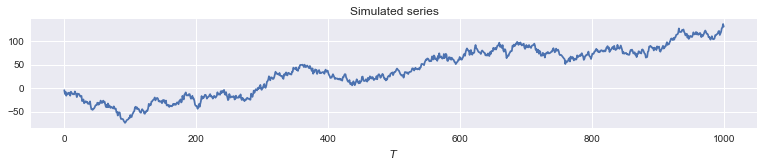

In [2]:
# True values
T = 1000
sigma2_eps0 = 3
sigma2_eta0 = 10

# Simulate data
np.random.seed(1234)
eps = np.random.normal(scale=sigma2_eps0**0.5, size=T)
eta = np.random.normal(scale=sigma2_eta0**0.5, size=T)
mu = np.cumsum(eta)
y = mu + eps

# Plot the time series
fig, ax = plt.subplots(figsize=(13,2))
ax.plot(y);
ax.set(xlabel='$T$', title='Simulated series');

It turns out it will be convenient to write the model in terms of the precision of $\varepsilon$, defined to be $h^{-1} \equiv \sigma_\varepsilon^2$, and the ratio of the variances: $q \equiv \sigma_\eta^2 / \sigma_\varepsilon^2$ so that $q h^{-1} = \sigma_\eta^2$.

Then our error terms can be written:

$$
\varepsilon_t \sim N(0, h^{-1}) \\
\eta_t \sim N(0, q h^{-1}) \\
$$

And the true values are:

- $h_0^{-1} = 1 / 3 = 0.33$
- $q = 10 / 3 = 3.33$

To take a Bayesian approach to this problem, we assume that $\psi$ is a random variable, and we want to learn about the values of $\psi$ based on the data $Y_T$; in fact we want a density $p(\psi | Y_T)$. To do this, we use Bayes rule to write:

$$
p(\psi | Y_T) = \frac{p(Y_T | \psi) p(\psi)}{p(Y_T)}
$$

or

$$
\underbrace{p(\psi | Y_T)}_{\text{posterior}} \propto \underbrace{p(Y_T | \psi)}_{\text{likelihood}} \underbrace{p(\psi)}_{\text{prior}}
$$

The object of interest is the posterior; to achieve it we need to specify a prior density for the unknown parameters and the likelihood function of the model.

### Prior

We will use the following priors:

#### Precision

Since the precision must be positive, but has no theoretical upper bound, we use a Gamma prior:

$$h \sim \text{Gamma}(\alpha_h, \beta_h)$$

to be specific, the density is written:

$$p(h) = \frac{\beta_h^{\alpha_h}}{\Gamma(\alpha)} h^{\alpha_h-1}e^{-\beta_h h}$$

and we set the hyperparameters as $\alpha_h = 2, \beta_h = 2$. In this case, we have $E(h) = \alpha_h / \beta_h = 1$ and also $E(h^{-1}) = E(\sigma_\varepsilon^2) = 1$.

#### Ratio of variances

Similarly, the ratio of variances must be positive, but has no theoretical upper bound, so we again use an (independent) Gamma prior:

$$q \sim \text{Gamma}(\alpha_q, \beta_q)$$

and we set the same hyperparameters, so $\alpha_q = 2, \beta_q = 2$. Since $E(q) = 1$, our prior is of equal variances. We then have $E(\sigma_\eta^2) = E(q h^{-1}) = E(q) E(h^{-1}) = 1$.

#### Initial state prior

As noted above, the Kalman filter must be initialized with $\mu_0 \sim N(m_0, P_0)$. We will use the following approximately diffuse prior:

$$\mu_0 \sim N(0, 10^6)$$

### Likelihood

For given parameters, likelihood of this model can be calculated via prediction error decomposition using an application of the Kalman filter iterations.

### Posterior Simulation: Metropolis-Hastings

One option for describing the posterior is via MCMC posterior simulation methods. The Metropolis-Hastings algorthm is simple and only requires the ability to *evaluate* the prior densities and the likelihood. The priors have known densities, and the likelihood function can be computed using the state space models from the [Statsmodels](http://www.statsmodels.org/) `tsa.statespace` package. We will use the [PyMC](https://pymc-devs.github.io/pymc/) package to streamline specification of priors and sampling in the Metropolis-Hastings case.

The `statespace` package is meant to make it easy to specify and evaluate state space models. Below, we create a new `LocalLevel` class. Among other things, it inherits from `MLEModel` a `loglike` method which we can use to evaluate the likelihood at various parameters.

In [3]:
# Priors
precision = mc.Gamma('precision', 2, 4)
ratio = mc.Gamma('ratio', 2, 1)

# Likelihood calculated using the state-space model
class LocalLevel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(LocalLevel, self).__init__(endog, k_states=1,
                                         initialization='approximate_diffuse',
                                         loglikelihood_burn=1)
        
        # Initialize known components of the state space matrices
        self.ssm['design', :] = 1
        self.ssm['transition', :] = 1
        self.ssm['selection', :] = 1
    
    @property
    def start_params(self):
        return [1. / np.var(self.endog), 1.]
    
    @property
    def param_names(self):
        return ['h_inv', 'q']
    
    def update(self, params, transformed=True, **kwargs):
        params = super(LocalLevel, self).update(params, transformed, **kwargs)
        
        h, q = params
        sigma2_eps = 1. / h
        sigma2_eta = q * sigma2_eps
        
        self.ssm['obs_cov', 0, 0] = sigma2_eps
        self.ssm['state_cov', 0, 0] = sigma2_eta

# Instantiate the local level model with our simulated data
ll_mod = LocalLevel(y)
ll_mod.filter(ll_mod.start_params)

# Create the stochastic (observed) component
@mc.stochastic(dtype=LocalLevel, observed=True)
def local_level(value=ll_mod, h=precision, q=ratio):
    return value.loglike([h, q], transformed=True)

# Create the PyMC model
ll_mc = mc.Model((precision, ratio, local_level))

# Create a PyMC sample
ll_sampler = mc.MCMC(ll_mc)

## Bayesian Estimation: Metropolis-Hastings

Now that we have specified our priors and likelihood, and wrapped it up in a PyMC `Model` and `MCMC` sampler, we can easily sample from the posterior.

 [-----------------100%-----------------] 10000 of 10000 complete in 20.6 secPlotting precision
Plotting ratio


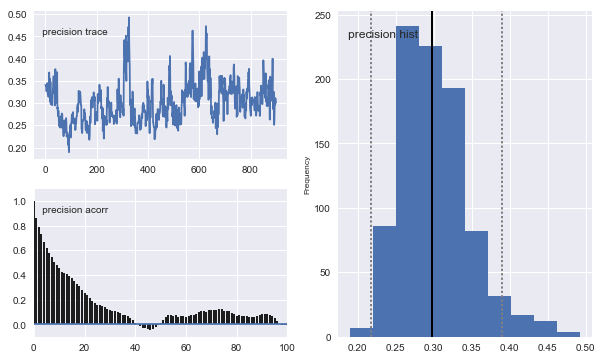

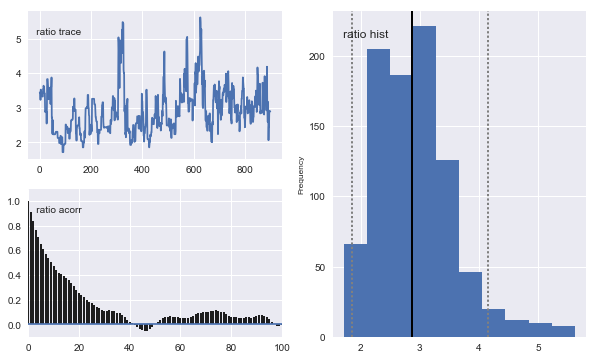

In [4]:
# Sample
ll_sampler.sample(iter=10000, burn=1000, thin=10)

# Plot traces
mc.Matplot.plot(ll_sampler)

Notice that the means of the posterior densities are close to the true values of the parameters.

## Classical Estimation

In addition to defining the state space models, Statsmodels allows easy estimation of parameters via maximum likelihood. For comparison, here is the output from MLE:

In [5]:
ll_res = ll_mod.fit()
print ll_res.summary()

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                     LocalLevel   Log Likelihood               -2789.529
Date:                Sun, 22 Jan 2017   AIC                           5583.058
Time:                        14:20:17   BIC                           5592.873
Sample:                             0   HQIC                          5586.788
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
h_inv          0.3045      0.049      6.196      0.000       0.208       0.401
q              2.9588      0.690      4.289      0.000       1.607       4.311
Ljung-Box (Q):                       37.10   Jarque-

These also closely match the true parameter values.

## Alternate Model: ARIMA(0,1,1)

It can be shown (see e.g. Harvey (1989), among many others) that the local level model is equivalent to an ARIMA(0,1,1) model, which is written:

$$\Delta y_t = \theta \zeta_{t-1} + \zeta_t, \qquad \zeta_t \sim N(0, \sigma_\zeta^2)$$

It is important to note that $\sigma_\zeta^2$ here is not equivalent to $\sigma_\varepsilon^2$ from the local level model. However, we can connect the models through $q = - (1 + \theta)^2 / \theta$. Note that to generate a valid $q$, $\theta$ must be negative.

We will use the same Gamma prior as above on the precision $h^{-1} = \sigma_\eta^2$, but we must specify a new prior for $\theta$. We will specify that $-\theta \equiv \gamma \sim \text{Beta}(\alpha_\theta, \beta_\theta)$. Since the entire support for the Beta distribution falls between 0 and 1, this prior implies $\theta \in [-1, 0]$. We would expect that $\hat \theta \approx -0.21$, since then $q = \frac{-(1 - 0.21)^2}{-0.21} \approx 3$ (and so $\hat \gamma \approx 0.21$).

Above, we defined a new state space model (`LocalLevel`), but we can also use built-in models if the one we want is available. Statsmodels has a `statespace.SARIMAX` class that can handle the specification and likelihood evaluation for an ARIMA(0,1,1) model, and we can simply instantiate it here.

In [6]:
# Priors
arima_precision = mc.Gamma('arima_precision', 2, 4)
gamma = mc.Beta('gamma', 2, 1)

# Instantiate the ARIMA model with our simulated data
arima_mod = sm.tsa.SARIMAX(y, order=(0,1,1))

# Create the stochastic (observed) component
@mc.stochastic(dtype=sm.tsa.SARIMAX, observed=True)
def arima(value=arima_mod, h=arima_precision, gamma=gamma):
    # Rejection sampling
    if gamma < 0 or h < 0:
        return 0
    return value.loglike(np.r_[-gamma, 1./h], transformed=True)

# Create the PyMC model
arima_mc = mc.Model((arima_precision, gamma, arima))

# Create a PyMC sample
arima_sampler = mc.MCMC(arima_mc)

## Bayesian Estimation: Metropolis-Hastings

 [-----------------100%-----------------] 10000 of 10000 complete in 29.1 secPlotting gamma
Plotting arima_precision


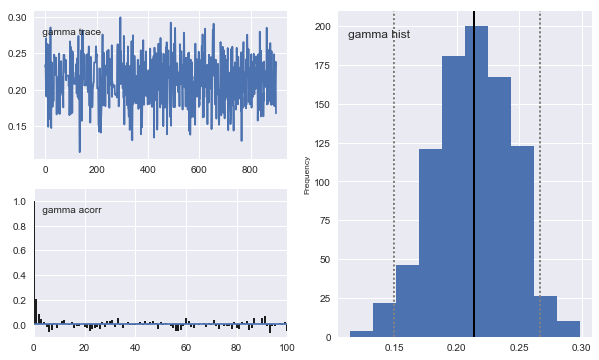

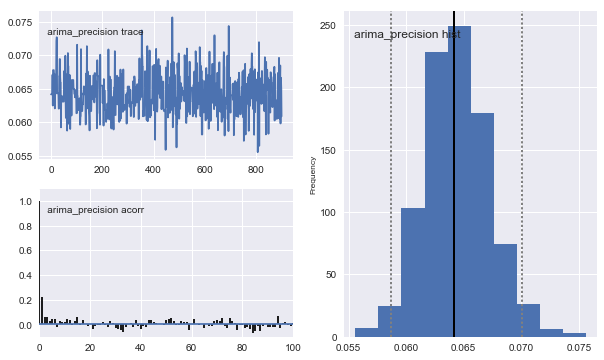

In [7]:
# Sample
arima_sampler.sample(iter=10000, burn=1000, thin=10)

# Plot traces
mc.Matplot.plot(arima_sampler)

## Classical Estimation

In [8]:
arima_res = arima_mod.fit()
print arima_res.summary()

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2789.529
Date:                Sun, 22 Jan 2017   AIC                           5583.058
Time:                        14:20:48   BIC                           5592.873
Sample:                             0   HQIC                          5586.788
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2106      0.032     -6.576      0.000      -0.273      -0.148
sigma2        15.5913      0.667     23.386      0.000      14.285      16.898
Ljung-Box (Q):                       37.10   Jarque-

## Forecasts

To see that the models are the same, we can check that they make the same one-step-ahead predictions.

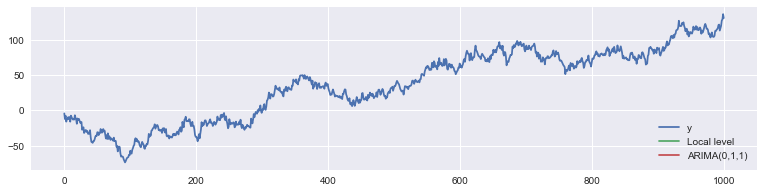

In [9]:
fig, ax = plt.subplots(figsize=(13,3))

ax.plot(y, label='y')
ax.plot(ll_res.predict()[0], label='Local level')
ax.plot(arima_res.predict()[0], label='ARIMA(0,1,1)')
ax.legend(loc='lower right');

In fact they're so close, it's hard to visually see just how close they are:

In [10]:
print(np.max(np.abs(arima_res.predict()[0] - ll_res.predict()[0])))

0.0
